In [54]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt

# Чтение данных

In [29]:
train = pd.read_csv('features.csv')

train.head()

,match_id,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
0,0,1430198770,7,11,5,2098,1489,20,0,0,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1,1430220345,0,42,4,1188,1033,9,0,1,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,2,1430227081,7,33,4,1319,1270,22,0,0,...,4,3,1,13.0,2130,0,0,1830,0,63
3,3,1430263531,1,29,4,1779,1056,14,0,0,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,4,1430282290,7,13,4,1431,1090,8,1,0,...,3,3,0,-16.0,2449,0,4,1974,3,63


## 1. Поиск пропусков.
Найдём все столбцы, в которых есть пропуски.

In [30]:
train.columns[train.isna().any()].tolist()

['first_blood_time',
 'first_blood_team',
 'first_blood_player1',
 'first_blood_player2',
 'radiant_bottle_time',
 'radiant_courier_time',
 'radiant_flying_courier_time',
 'radiant_first_ward_time',
 'dire_bottle_time',
 'dire_courier_time',
 'dire_flying_courier_time',
 'dire_first_ward_time']

- пропуски связаны с тем, что событие ещё не произошло за первые 5 минут. Например, не произошло первое убийство, поэтому есть пропуски в колонках `first_blood_time`, `first_blood_team`.

### Заполнение пропусков
- всё что связано со временем, нужно заполнить некоторым специальным значением. По хорошему, нужно взять полный датасет и проставить среднее значение по данному параметру за всю игру. В качестве приближения возьмём 10 минут (из опыта игры в `Dota 2` :) 

In [31]:
features_with_time = [
 'first_blood_time', 
 'radiant_bottle_time',
 'radiant_courier_time',
 'radiant_flying_courier_time',
 'radiant_first_ward_time',
 'dire_bottle_time',
 'dire_courier_time',
 'dire_flying_courier_time',
 'dire_first_ward_time']

train[features_with_time] = train[features_with_time].fillna(600)

- `first_blood_team` заполним значением `0.5`, чтобы сохранить порядок на множестве.
- `first_blood_player` заполним специальным значением `10`. Обычные значения из множества $\{0, \ldots, 9 \}$.

In [32]:
train['first_blood_team'] = train['first_blood_team'].fillna(0.5)
train['first_blood_player1'] = train['first_blood_player1'].fillna(10)
train['first_blood_player2'] = train['first_blood_player2'].fillna(10)

### Целевая переменная

In [33]:
train['radiant_win']

0        1
1        1
2        0
3        0
4        0
        ..
97225    0
97226    1
97227    0
97228    0
97229    1
Name: radiant_win, Length: 97230, dtype: int64

- в данной колонке нет пропуском, значит данные размечены. `radiant_win = 1` означает победу сил света, `radiant = 0` -- победу сил тьмы. 

### Подготовка данных

- удалим признаки, которые содержат данные не о первых пяти минутах.

In [34]:
Y = np.array(train['radiant_win'])

del train['radiant_win']
del train['duration']
del train['tower_status_radiant']
del train['tower_status_dire']
del train['barracks_status_radiant']
del train['barracks_status_dire']


X = np.array(train)

## 2. Gradient boosting.
- проведём обучение на 10, 20, 30, 40, 50 деревьях, замерим время работы на кросс-валидации. Время будем замерять с помощью `datetime`.
- препроцессинг данных не будем проводить, так как метод нетребователен к данным.
- метрика качества -- `AUC-ROC`.

In [36]:
cv = KFold(shuffle=True, random_state=241)

In [98]:
n_tree = [10, 20, 30, 40, 50]

scores = []

for N in n_tree:
    start_time = datetime.datetime.now()
    clf = GradientBoostingClassifier(n_estimators=N, random_state=241)
    score = cross_val_score(estimator=clf, X=X, y=Y, cv=cv, scoring='roc_auc')
    print (f'Time elapsed = {datetime.datetime.now() - start_time} for {N} trees')
    scores.append(np.mean(score))

Time elapsed = 0:00:58.189749 for 10 trees
Time elapsed = 0:01:49.826183 for 20 trees
Time elapsed = 0:02:41.994059 for 30 trees
Time elapsed = 0:03:36.859486 for 40 trees
Time elapsed = 0:04:30.720865 for 50 trees


### Визуализация 
- построим зависимость `scores` от `n_tree`. Исследуем переобучаемость алгоритма.

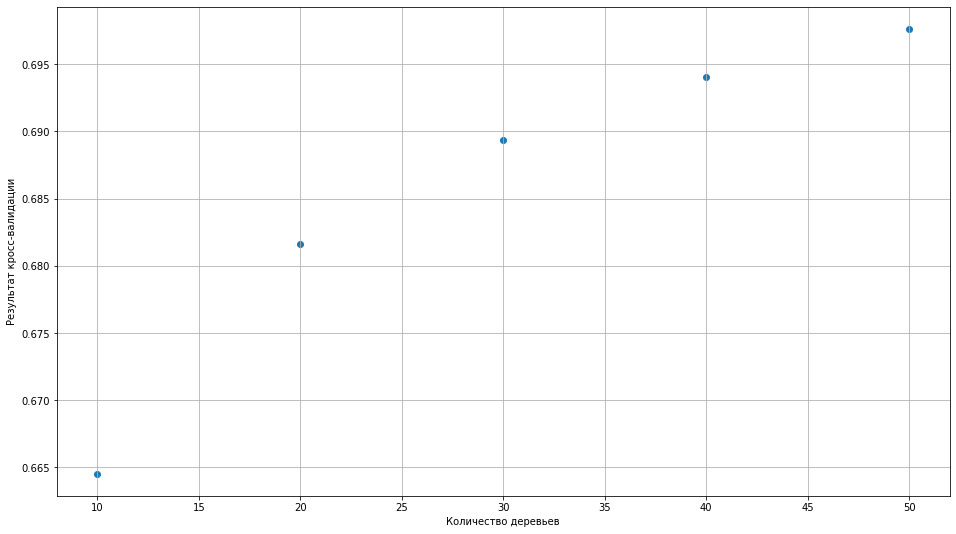

In [99]:
plt.figure(figsize=(16, 9))

plt.scatter(
    n_tree,
    scores
)

plt.ylabel('Результат кросс-валидации')
plt.xlabel('Количество деревьев')
plt.grid()
plt.show()

In [100]:
print(f'Best_score = {np.max(scores)}')

Best_score = 0.6976361364643674


- из графика видно, что результат кросс-валидации растёт. Но это может говорить, как о переобучаемости алгоритма, так и о его лучшей настройке. Но как показывает практика оптимальное значение деревьев около 30-50 при `learning_rate = 0.1; 0.2`.

### Уменьшение времени обучения
- обучим алгоритм с меньшим значением `max_depth` и сравним время, и значение метрики.

In [90]:
start_time = datetime.datetime.now()
clf = GradientBoostingClassifier(n_estimators=30, random_state=241, max_depth=2)
score = cross_val_score(estimator=clf, X=X, y=Y, cv=cv, scoring='roc_auc')
print (f'Time elapsed = {datetime.datetime.now() - start_time} for 30 trees and max_depth = 2')
print(f'score = {np.mean(score)}')

Time elapsed = 0:01:49.591718 for 30 trees and max_depth = 2
score = 0.682146778547861


### Вывод:
- алгоритм довольно долго обучается, причём скорость обучения линейно зависит от количесва деревьев.
- качество обучения оптимально при количестве деревьев около 30-50 при `learning_rate`, поэтому можно снизить время обучения за счёт обучения, например, не при 50 деревьях, а при 30. Зачастую это будет лучше и с точки зрения переобучения.
- также время обучения можно умньшить за счёт уменьшения максимальной глубины деревьев `max_depth`, но так же придётся немного пожертвовать `cross_val_score`.
- можно уменьшить выборку для обучения, что также повлечёт уменьшение времени обучения.

## 3. Логистическая регрессия.
Линейные классификаторы обучаются быстрее градиентного бустинга, но они более требовательны ко входным данным.

- будем проводить обучение с $L_2$ регуляризацией. Найдём оптимальную константу регуляризации из кросс-валидации.
- из препроцессинга данных сделаем пока только `Scale` всех признаков.

In [88]:
C_values = [i for i in range(1, 22, 2)]

scaler = StandardScaler()
cv = KFold(shuffle=True, random_state=241)

#find best C
C_best = 0
best_score = 0
scores = []

for C_ in C_values:
    start_time = datetime.datetime.now()
    clf = LogisticRegression(penalty='l2', random_state=241, C=C_)
    pipeline = Pipeline([('transformer', scaler), ('estimator', clf)])
    scores_ = cross_val_score(pipeline, X, Y, cv = cv, scoring='roc_auc')
    print (f'Time elapsed = {datetime.datetime.now() - start_time} for C={C_}')
    scores.append(np.mean(scores_))
    if np.mean(scores_) > best_score:
        best_score = np.mean(scores_)
        C_best = C
 

Time elapsed = 0:00:08.101583 for C=1
Time elapsed = 0:00:08.109693 for C=3
Time elapsed = 0:00:07.914708 for C=5
Time elapsed = 0:00:07.528880 for C=7
Time elapsed = 0:00:07.504719 for C=9
Time elapsed = 0:00:07.455549 for C=11
Time elapsed = 0:00:07.459767 for C=13
Time elapsed = 0:00:07.556747 for C=15
Time elapsed = 0:00:07.484555 for C=17
Time elapsed = 0:00:07.485413 for C=19
Time elapsed = 0:00:07.464153 for C=21


### Визуализация
Проиллюстрируем зависимость метрики качества от константы регуляризации.

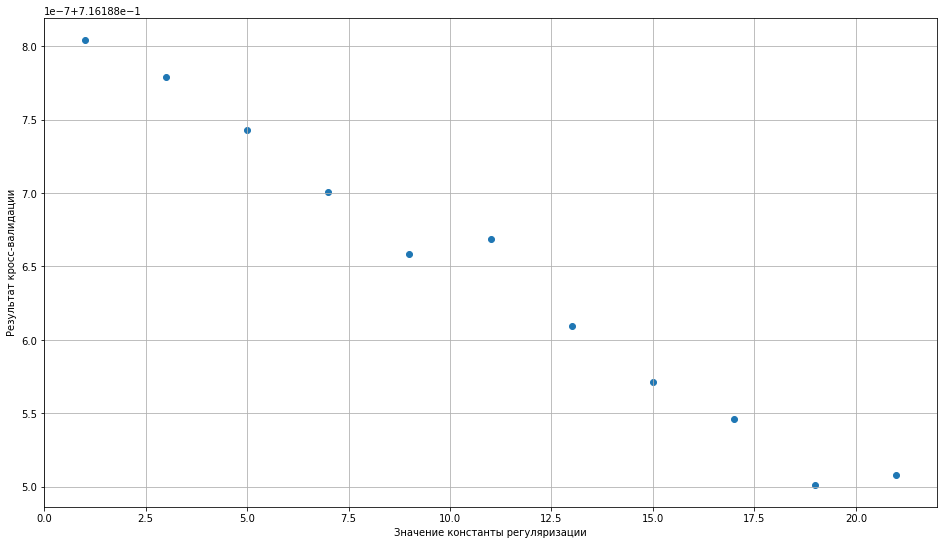

In [91]:
plt.figure(figsize=(16, 9))

plt.scatter(
    C_values,
    scores
)

plt.ylabel('Результат кросс-валидации')
plt.xlabel('Значение константы регуляризации')
plt.grid()
plt.show()

In [94]:
print(f'Best score = {best_score}, C = {C_best}')

Best score = 0.7161888044326512, C = 1


### Вывод
- линейный классификатор намного быстрее обучается, что является несомненным плюсом.
- так же при значении `C = 1` результат на кросс-валидации лучшем, чем у градиентного бустинга. Конечно в градиентном бустинге можно было бы выбрать большее количество деревье, и тогда этот метод показал бы лучший результат, но слишком велик шанс переобучения.
- данные действительно пришлось несколько обработать, но до сих пор данные довольно в сыром виде. Попытаемся дальше улучшить качество входных данных и повысить результат.

## 3.1 Логистическая регрессия с препроцессингом
- сначала просто попробуем удалить категориальные признаки

In [138]:
#delete features
cat_f = [
    'lobby_type',
    'r1_hero',
    'r2_hero', 
    'r3_hero', 
    'r4_hero',
    'r5_hero',
    'd1_hero', 
    'd2_hero', 
    'd3_hero', 
    'd4_hero',
    'd5_hero'
]

col_without_cat = list(set(train.columns[:].tolist()) - set(cat_f))

X_wc = np.array(train[col_without_cat])

In [105]:
clf = LogisticRegression(penalty='l2', random_state=241, C=1) 
pipeline = Pipeline([('transformer', scaler), ('estimator', clf)])
scores_ = cross_val_score(pipeline, X_wc, Y, cv = cv, scoring='roc_auc')
print(f'Score without category feature = {np.mean(scores_)}')

Score without category feature = 0.7162694331678416


### Замечание
- качество уже улучшилось, так как мы раньше по ошибке принимали категориальные признаки за числовые.
- на самом деле это важные категориальные признаки, можно их аккуратно добавить обратно и тем самым повысить качество классификатора.

In [133]:
for_counting = train['r1_hero']
num_heroes = max(for_counting)
print(f'Number of heroes = {num_heroes}')

Number of heroes = 112


 ### Формирование мешка слов.

In [135]:
X_pick = np.zeros((len(train), num_heroes))

In [136]:
X_pick = pd.DataFrame(X_pick)
for i, match_id in enumerate(train.index):
    for p in range(5):
        X_pick.iloc[i, train.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick.iloc[i, train.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1

In [151]:
X_pick.index = train.index

In [153]:
#prepare data
X_preprocessed = pd.concat([train[col_without_cat], X_pick], 
                           axis=1)

### Обучение

In [154]:
clf = LogisticRegression(penalty='l2', random_state=241, C=1) 
pipeline = Pipeline([('transformer', scaler), ('estimator', clf)])
scores_ = cross_val_score(pipeline, X_preprocessed, Y, cv = cv, scoring='roc_auc')
print(f'Score with preprocessed data = {np.mean(scores_)}')

Score with preprocessed data = 0.7520702038814976


In [212]:
clf.fit(X_preprocessed, Y)

LogisticRegression(C=1, random_state=241)

### Вывод
- Постепенная обработка данных дала прирост `score` с 0.716 до 0.752. 
- Основной вклад в прирост дало формирование мешков по категориальным признакам. Это говорит о том, что действительно, как и предполагалось, эти признаки были важны.

## 4. Проверка финальной модели

In [176]:
test = pd.read_csv('features_test.csv', index_col='match_id')

### Препроцессинг

In [177]:
#fill NaN
test[features_with_time] = test[features_with_time].fillna(600)
test['first_blood_team'] = test['first_blood_team'].fillna(0.5)
test['first_blood_player1'] = test['first_blood_player1'].fillna(10)
test['first_blood_player2'] = test['first_blood_player2'].fillna(10)

In [188]:
#make X_pick_test
X_pick_test = np.zeros((len(test), num_heroes))

X_pick_test = pd.DataFrame(X_pick_test)
for i, match_id in enumerate(test.index):
    for p in range(5):
        X_pick_test.iloc[i, test.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick_test.iloc[i, test.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1

X_pick_test.index = test.index

In [189]:
#prepare data
X_test = pd.concat([test[col_without_cat], X_pick_test], 
                           axis=1)

In [200]:
#scaling
X_preprocessed = scaler.fit_transform(X_preprocessed)
X_test = scaler.transform(X_test)

### Обучение

In [205]:
clf_best = LogisticRegression(penalty='l2', random_state=241, C=1).fit(X_preprocessed, Y)

In [208]:
probas = clf_best.predict_proba(X_test)

In [211]:
print(f'max probability = {max(probas[:, 1])}')
print(f'min probability = {min(probas[:, 1])}')

max probability = 0.7225223130624056
min probability = 0.02126647951247359


### Вывод
- классификатор выдаёт адекватные значения. Осталось только протестировать его на `Kaggle`.